In [1]:
import os
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.io import loadmat
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


np.random.seed(42)

In [2]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window


def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    # Calculate the mean, standard deviation, and maximum amplitude along axis 1 (time axis)
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(np.abs(EMG_windows), axis=1)
    
    # Calculate the mean of the labels for each window (along axis 1, which is time)
    Labels_mean = np.mean(Labels_windows, axis=1)
    
    # Concatenate the features (mean, std, max amplitude) along axis 1 (features for each window)
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    
    return EMG_extracted_features, Labels_mean

# 1. Load and visualize data (emg_data and joint_data_index (from glove)) 
# 2. Perform sliding windows

In [3]:
extraction_dir = 'data_part3_S1'  

# Charger les fichiers .mat avec scipy.io.loadmat
file_paths = [
    os.path.join(extraction_dir, 'S1_E1_A1.mat'),
    os.path.join(extraction_dir, 'S1_E1_A2.mat'),
    os.path.join(extraction_dir, 'S1_E1_A3.mat')
]

Here we will iterate over the 3 exercises sets to:
- get the emg data
- get the glove data
- visualize the angles of each joint along with the emg data
- get the EMG and label windows

EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>
Joint data dimension: (2292526, 5)
Joint data type: <class 'numpy.ndarray'>

EMG and Joint Angles for Exercise Set E1:


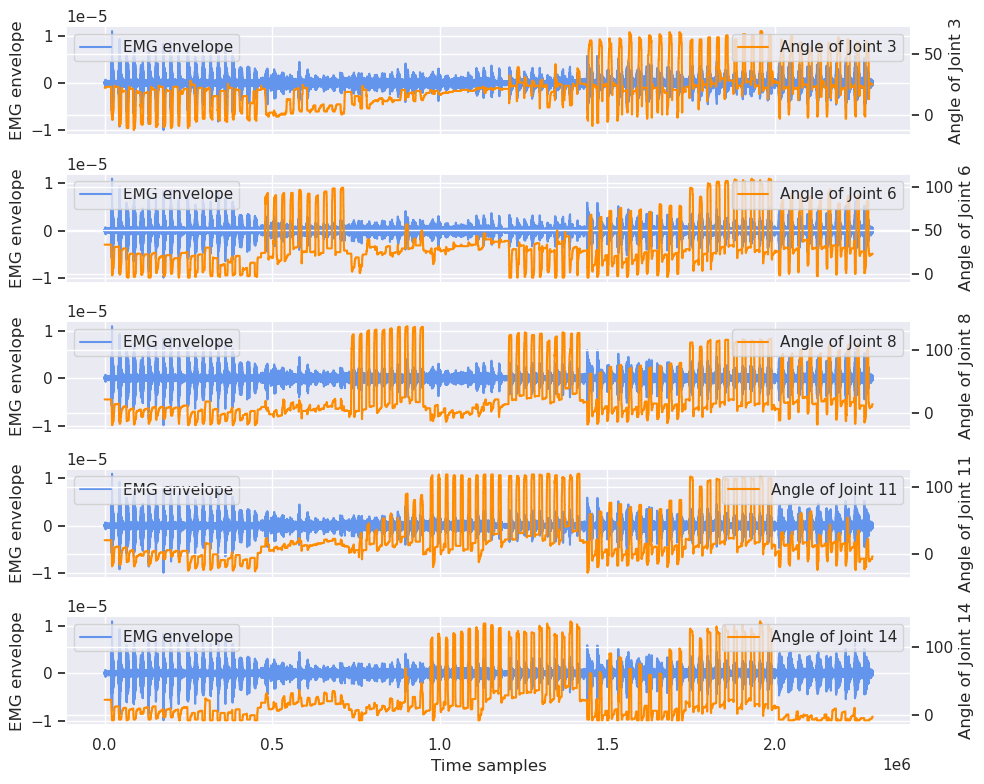

EMG data dimension: (2313470, 16)
EMG data type: <class 'numpy.ndarray'>
Joint data dimension: (2313470, 5)
Joint data type: <class 'numpy.ndarray'>

EMG and Joint Angles for Exercise Set E2:


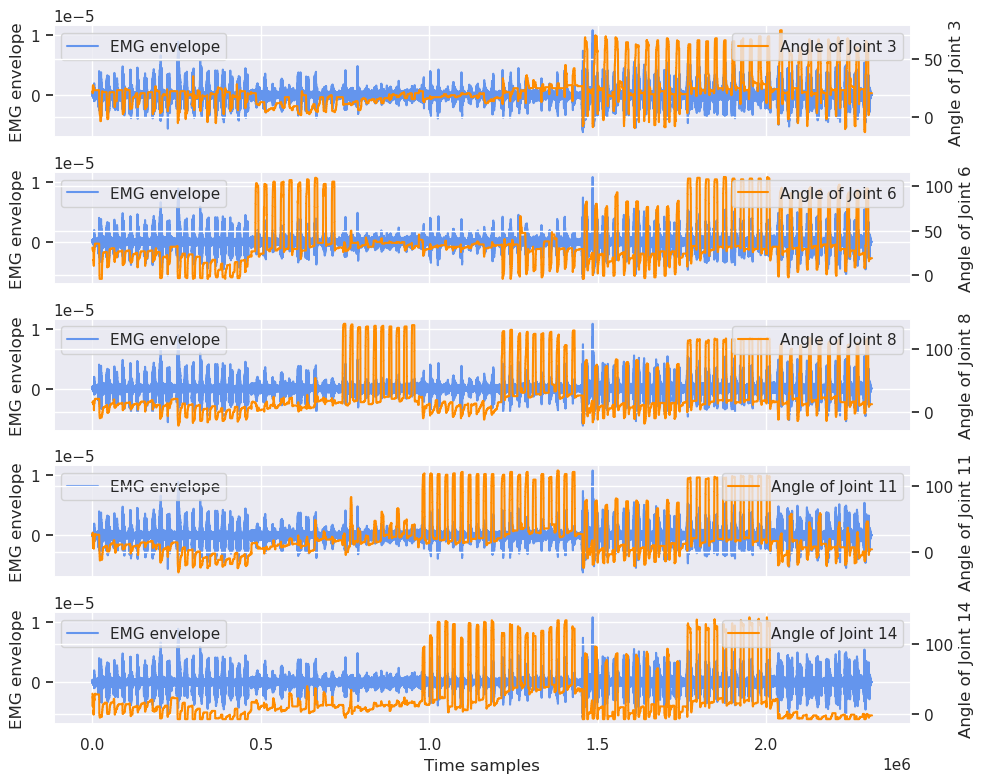

EMG data dimension: (529099, 16)
EMG data type: <class 'numpy.ndarray'>
Joint data dimension: (529099, 5)
Joint data type: <class 'numpy.ndarray'>

EMG and Joint Angles for Exercise Set E3:


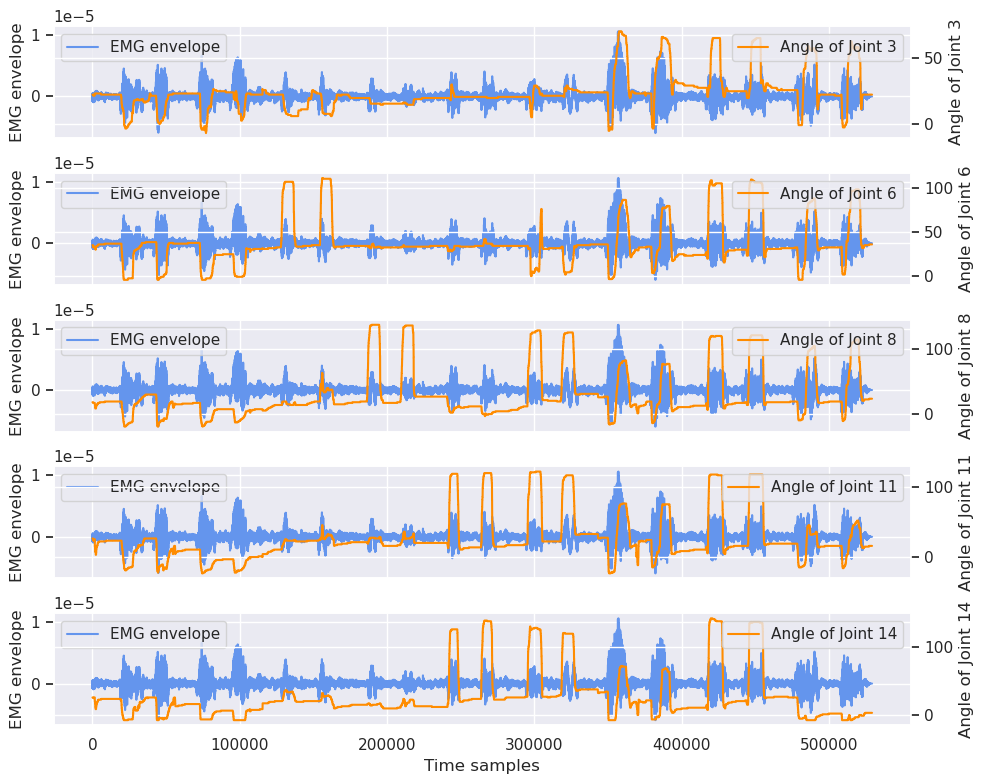

In [4]:
exercise_sets = ['E1', 'E2', 'E3']
data_index_where_movement_ends = 10000000 #we choose to stop arbitrary after 2 000 000 time steps to have enough data

all_EMG_windows = {}
all_labels_windows = {}

for x, set in enumerate (exercise_sets):
    
    mat_data = scipy.io.loadmat(file_paths[x])
    emg_data = mat_data["emg"]
    emg_data = emg_data[:data_index_where_movement_ends,:]
    print("EMG data dimension: {}".format(emg_data.shape))
    print("EMG data type: {}".format(type(emg_data)))

    joint_indices = [2, 5, 7, 10, 13]
    joint_data_index = mat_data["glove"][:data_index_where_movement_ends, joint_indices]
    print("Joint data dimension: {}".format(joint_data_index.shape))
    print("Joint data type: {}".format(type(joint_data_index)))

    mov_mean_size = 400
    mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
    EMG_envelopes = convolve1d(emg_data, weights=mov_mean_weights, axis=0)
    
    joint_indices = [0, 1, 2, 3, 4] 
    
    joint_names = ["Joint 3", "Joint 6", "Joint 8", "Joint 11", "Joint 14"]
    
    fig, axs = plt.subplots(len(joint_indices), 1, figsize=(10, 8), sharex=True)
    
    for i, joint_index in enumerate(joint_indices):
        finger_angle_ax = axs[i].twinx()
        
        axs[i].plot(EMG_envelopes[:, 0], color='cornflowerblue', label="EMG envelope")
        axs[i].set_ylabel("EMG envelope")
        
        finger_angle_ax.plot(joint_data_index[:, joint_index], color="darkorange", label=f"Angle of {joint_names[i]}")
        finger_angle_ax.set_ylabel(f"Angle of {joint_names[i]}")
        
        axs[i].legend(loc='upper left')
        finger_angle_ax.legend(loc='upper right')
        
        axs[i].grid(True)
    
    axs[-1].set_xlabel("Time samples")
    print()
    print(f'EMG and Joint Angles for Exercise Set {set}:')
    plt.tight_layout()
    
    plt.show()

    fs = 1111  # [Hz], from dataset description
    emg_window_length_sec = 128e-3  # from dataset description
    incremental_window_length_sec = 50e-3  # from dataset description

    EMG_windows, Labels_windows = extract_time_windows_regression(EMG_envelopes, joint_data_index, fs, emg_window_length_sec, incremental_window_length_sec)
    
    all_EMG_windows[f"EMG_windows_E{x + 1}"] = EMG_windows
    all_labels_windows[f"labels_E{x + 1}"] = Labels_windows

    


# 3. Split into train, validation, test sets.
As suggested in the forum, we used E2 for training, E1 for validation and E3 for testing.

In [6]:
EMG_train = all_EMG_windows["EMG_windows_E1"]
Labels_train = all_labels_windows["labels_E1"]

EMG_val = all_EMG_windows["EMG_windows_E2"]
Labels_val = all_labels_windows["labels_E2"]

EMG_test = all_EMG_windows["EMG_windows_E3"]
Labels_test = all_labels_windows["labels_E3"]

# 4. Extract set of features, normalize and visualize

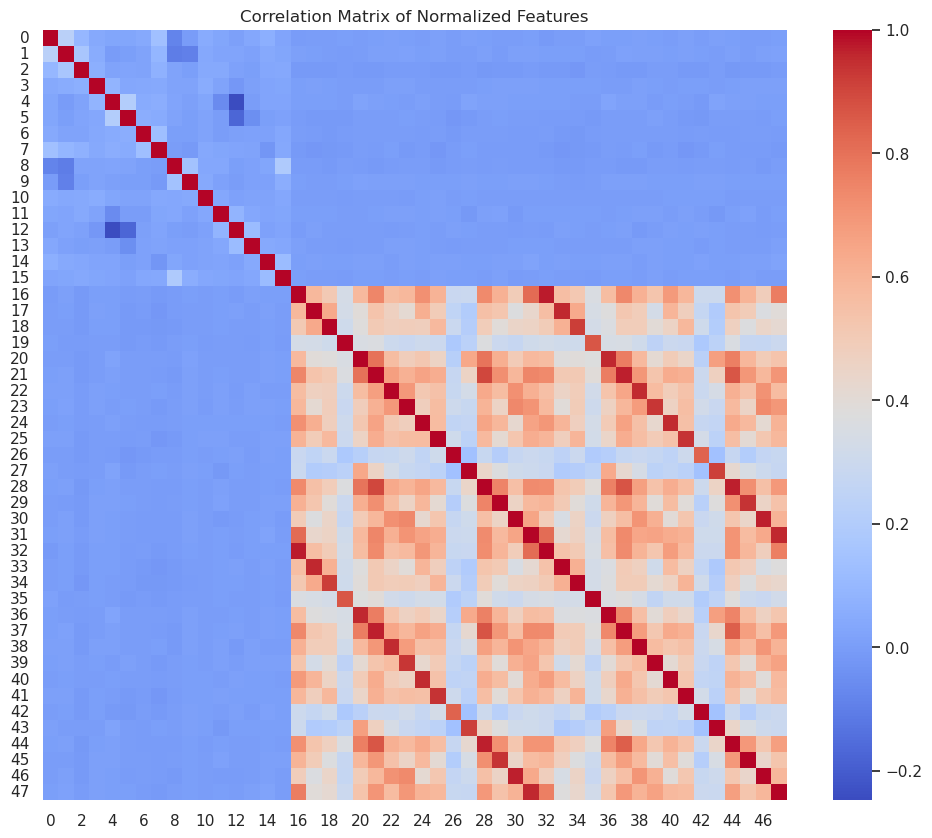

In [7]:
# we extract the 3 features for each channel and in each exercise set
EMG_train_features, Labels_train_mean = extract_features(EMG_train, Labels_train)
EMG_val_features, Labels_val_mean = extract_features(EMG_val, Labels_val)
EMG_test_features, Labels_test_mean = extract_features(EMG_test, Labels_test)

# then we normalize the features
scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(EMG_train_features)

X_val_normalized = scaler.transform(EMG_val_features)
X_test_normalized = scaler.transform(EMG_test_features)


X_train_normalized_df = pd.DataFrame(X_train_normalized)

#plot the correlation matrix for training set features
correlation_matrix = X_train_normalized_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Normalized Features')
plt.show()

# 5. Prediction on the kinematics
We did cross validation to try to have a better performance of the model

In [8]:
model = LinearRegression()

cv_scores = cross_val_score(model, X_train_normalized, Labels_train_mean, cv=5, scoring='neg_mean_squared_error')

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"Cross-Validation Mean MSE: {-mean_cv_score:.4f}")
print(f"Cross-Validation Standard Deviation: {std_cv_score:.4f}")

model.fit(X_train_normalized, Labels_train_mean)

val_predictions = model.predict(X_val_normalized)

val_mse = mean_squared_error(Labels_val_mean, val_predictions)
print(f"Validation Mean Squared Error: {val_mse:.4f}")

Cross-Validation Mean MSE: 1034.1036
Cross-Validation Standard Deviation: 279.6379
Validation Mean Squared Error: 755.0572


# 6. Performance evaluation

Test Mean Squared Error (Total): 809.6455
MSE for Joint 3: 181.7825
MSE for Joint 6: 593.2712
MSE for Joint 8: 1297.5637
MSE for Joint 11: 948.7478
MSE for Joint 14: 1026.8621


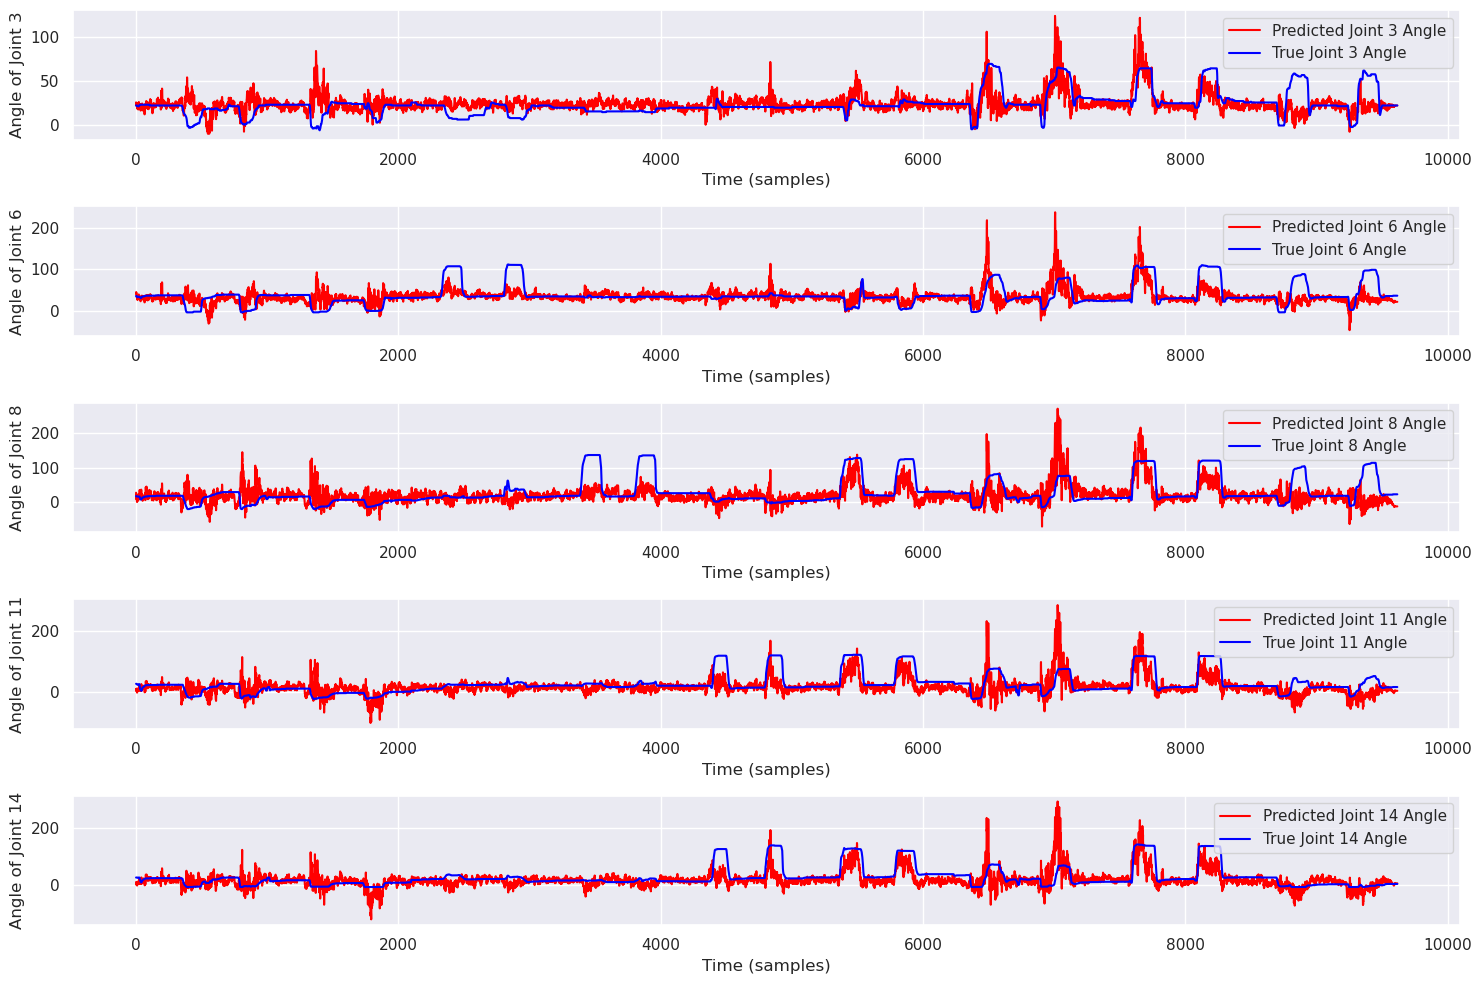

In [9]:
# make predictions on test set
test_predictions = model.predict(X_test_normalized)

# compute the mse on the entire test set
test_mse = mean_squared_error(Labels_test_mean, test_predictions)
print(f"Test Mean Squared Error (Total): {test_mse:.4f}")

# compute the mse for each joint separately
n_joints = Labels_test_mean.shape[1]
joint_mse = []

for i in range(n_joints):
    joint_mse_value = mean_squared_error(Labels_test_mean[:, i], test_predictions[:, i])
    joint_mse.append(joint_mse_value)
    print(f"MSE for {joint_names[i]}: {joint_mse_value:.4f}")

# show the MSE for each joint
joint_names = ["Joint 3", "Joint 6", "Joint 8", "Joint 11", "Joint 14"]

plt.figure(figsize=(15, 10))
#for each joint, plot true and predicted angles 
for i in range(n_joints):
    plt.subplot(n_joints, 1, i + 1)
    plt.plot(test_predictions[:, i], label=f"Predicted {joint_names[i]} Angle", color='red')
    plt.plot(Labels_test_mean[:, i], label=f"True {joint_names[i]} Angle", color='blue')
    plt.xlabel("Time (samples)")
    plt.ylabel(f"Angle of {joint_names[i]}")
    plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()
